In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# change your file path here
filepath = os.path.join(os.path.curdir, "data", "train_all_tasks.csv")
df = pd.read_csv(filepath)
df = df.drop(columns=['rewire_id'])
df.head()
len(df)

14000

#**TASK-A**

In [3]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text) 
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text) 
    return text

def remove_stopword(text, stopwords):
    return " ".join([word for word in text.split() if word not in (stop_words)])

def lemma_text(text, lemmatizer):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize(text)]
    return " ".join(lemmatized_words)

def tokenize(text):
    return text.split()

def process_text(text, lemmatizer, stop_words):
    text = clean_text(text)
    text = remove_stopword(text, stop_words)
    text = lemma_text(text, lemmatizer)
    return text 

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [4]:
df["processed_text"] = df['text'].apply(process_text, lemmatizer = lemmatizer, stop_words = stop_words)
df.head(5)

,text,label_sexist,label_category,label_vector,processed_text
0,"Damn, this writing was pretty chaotic",not sexist,none,none,damn writing pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none,yeah apparently bunch misogynistic virgin one ...
2,How the FUCK is this woman still an MP!!!???,not sexist,none,none,fuck woman still mp
3,Understand. Know you're right. At same time I ...,not sexist,none,none,understand know youre right time know isnt eno...
4,Surprized they didn't stop and rape some women,not sexist,none,none,surprized didnt stop rape woman


In [5]:
#Under sampling the data
# class count
class_notsexist, class_sexist = df['label_sexist'].value_counts()
class_notsexist, class_sexist
# # Separate class
class_s = df[df['label_sexist'] == "sexist"]
class_ns = df[df['label_sexist'] == "not sexist"]
print('class_s:', class_s.shape)
print('class_ns:', class_ns.shape)

class_s: (3398, 5)
class_ns: (10602, 5)


<AxesSubplot:title={'center':'count (target)'}>

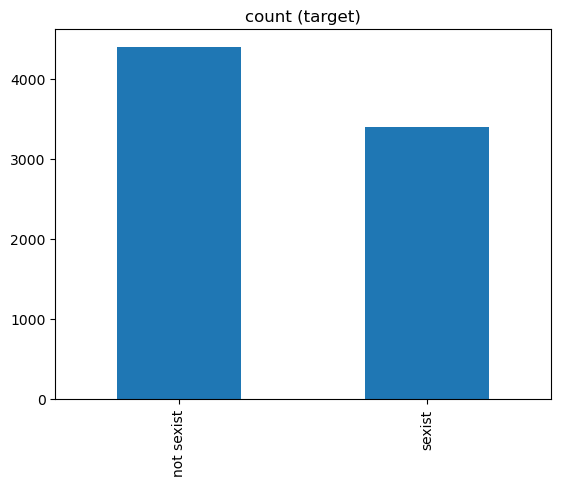

In [6]:
class_ns_under = class_ns.sample(class_sexist+1000)

df_under = pd.concat([class_ns_under, class_s], axis=0)
df_under['label_sexist'].value_counts().plot(kind='bar', title='count (target)')

In [7]:
tfidf = TfidfVectorizer()
tfidf_text_vec = tfidf.fit_transform(df_under.processed_text)

In [8]:
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(tfidf_text_vec, df_under['label_sexist'], test_size=0.2, train_size=0.8, random_state=5, shuffle=True)

**Logistic Regression**

In [9]:
lrm = LogisticRegression(penalty='l2', random_state=0).fit(x_train_a, y_train_a)
lrm_pred = lrm.predict(x_test_a)
acc = accuracy_score(lrm_pred, y_test_a)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, lrm_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, lrm_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_cls_report_logistic_reg.csv"), index= True)

Accuracy: 73.65%
              precision    recall  f1-score   support

  not sexist       0.71      0.89      0.79       883
      sexist       0.79      0.54      0.64       677

    accuracy                           0.74      1560
   macro avg       0.75      0.71      0.72      1560
weighted avg       0.75      0.74      0.73      1560



**Decision Tree**

In [10]:
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', max_features=20)
dt_clf.fit(x_train_a, y_train_a)
pred = dt_clf.predict(x_test_a)
acc = accuracy_score(pred, y_test_a)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_cls_report_logistic_decision_tree.csv"), index= True)

Accuracy: 60.19%
              precision    recall  f1-score   support

  not sexist       0.64      0.68      0.66       883
      sexist       0.54      0.51      0.52       677

    accuracy                           0.60      1560
   macro avg       0.59      0.59      0.59      1560
weighted avg       0.60      0.60      0.60      1560



**Xgboost Model**

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_a_enc = le.fit_transform(y_train_a)
y_test_a_enc = le.fit_transform(y_test_a)

In [12]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=5)
xgb_model.fit(x_train_a, y_train_a_enc)

y_pred = xgb_model.predict(x_test_a)
y_pred_enc = le.fit_transform(y_pred)

acc = accuracy_score(y_pred_enc, y_test_a_enc)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a_enc, y_pred_enc))
clsf_report = pd.DataFrame(classification_report(y_test_a_enc, y_pred_enc, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_cls_report_xgboost.csv"), index= True)

Accuracy: 74.29%
              precision    recall  f1-score   support

           0       0.74      0.83      0.79       883
           1       0.74      0.63      0.68       677

    accuracy                           0.74      1560
   macro avg       0.74      0.73      0.73      1560
weighted avg       0.74      0.74      0.74      1560



In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier().fit(x_train_a, y_train_a)
rf_pred = rf_clf.predict(x_test_a)
acc = accuracy_score(rf_pred, y_test_a)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, rf_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, rf_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_cls_report_random_forest.csv"), index= True)

Accuracy: 76.09%
              precision    recall  f1-score   support

  not sexist       0.75      0.86      0.80       883
      sexist       0.78      0.63      0.70       677

    accuracy                           0.76      1560
   macro avg       0.76      0.75      0.75      1560
weighted avg       0.76      0.76      0.76      1560



#**TASK-B**

In [14]:
df_b = df[df['label_category'] != 'none']
df = df_b
len(df)

3398

In [15]:
tfidf = TfidfVectorizer()
tfidf_text_vec = tfidf.fit_transform(df.processed_text)

In [16]:
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(tfidf_text_vec, df['label_category'], test_size=0.2, train_size=0.8, random_state=5, shuffle=True)

**Decision Tree**

In [17]:
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(x_train_b, y_train_b)
pred = dt_clf.predict(x_test_b)
acc = accuracy_score(pred, y_test_b)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_b, pred))
clsf_report = pd.DataFrame(classification_report(y_test_b, pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_b_cls_report_decision_tree.csv"), index= True)

Accuracy: 45.59%
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.26      0.15      0.19        65
                           2. derogation       0.52      0.59      0.55       321
                            3. animosity       0.43      0.42      0.42       230
               4. prejudiced discussions       0.27      0.23      0.25        64

                                accuracy                           0.46       680
                               macro avg       0.37      0.35      0.36       680
                            weighted avg       0.44      0.46      0.45       680



In [18]:
le = LabelEncoder()
y_train_b_enc = le.fit_transform(y_train_b)
y_test_b_enc = le.fit_transform(y_test_b)

**Xgboost Classifier**

In [19]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=5)
xgb_model.fit(x_train_b, y_train_b_enc)

y_pred = xgb_model.predict(x_test_b)
y_pred_enc = le.fit_transform(y_pred)

acc = accuracy_score(y_pred_enc, y_test_b_enc)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_b_enc, y_pred_enc))
clsf_report = pd.DataFrame(classification_report(y_test_b_enc, y_pred_enc, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_b_cls_report_xgboost.csv"), index= True)

Accuracy: 48.38%
              precision    recall  f1-score   support

           0       0.61      0.17      0.27        65
           1       0.51      0.72      0.60       321
           2       0.42      0.33      0.37       230
           3       0.42      0.16      0.23        64

    accuracy                           0.48       680
   macro avg       0.49      0.34      0.37       680
weighted avg       0.48      0.48      0.45       680



**RandomForest Classifier**

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=3, random_state=5).fit(x_train_b, y_train_b)
rf_pred = rf_clf.predict(x_test_b)
acc = accuracy_score(rf_pred, y_test_b)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_b, rf_pred))
clsf_report = pd.DataFrame(classification_report(y_test_b, rf_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_b_cls_report_random_forest.csv"), index= True)

Accuracy: 47.21%
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        65
                           2. derogation       0.47      1.00      0.64       321
                            3. animosity       0.00      0.00      0.00       230
               4. prejudiced discussions       0.00      0.00      0.00        64

                                accuracy                           0.47       680
                               macro avg       0.12      0.25      0.16       680
                            weighted avg       0.22      0.47      0.30       680



E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla

#**TASK-C**

In [21]:
df_c = df[df['label_vector'] != 'none']
df = df_c
len(df)

3398

In [22]:
tfidf = TfidfVectorizer()
tfidf_text_vec = tfidf.fit_transform(df.processed_text)

In [23]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(tfidf_text_vec, df['label_vector'], test_size=0.2, train_size=0.8, random_state=5, shuffle=True)

**Decision Tree**

In [24]:
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(x_train_c, y_train_c)
pred = dt_clf.predict(x_test_c)
acc = accuracy_score(pred, y_test_c)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_c, pred))
clsf_report = pd.DataFrame(classification_report(y_test_c, pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_c_cls_report_decision_tree.csv"), index= True)

Accuracy: 36.18%
                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.00      0.00      0.00         9
                       1.2 incitement and encouragement of harm       0.38      0.38      0.38        56
                                        2.1 descriptive attacks       0.38      0.48      0.43       139
                             2.2 aggressive and emotive attacks       0.44      0.37      0.40       141
        2.3 dehumanising attacks & overt sexual objectification       0.26      0.22      0.24        41
     3.1 casual use of gendered slurs, profanities, and insults       0.46      0.53      0.49       128
        3.2 immutable gender differences and gender stereotypes       0.28      0.26      0.27        77
                            3.3 backhanded gendered compliments       0.00      0.00      0.00        15
             3.4 condescending explan

**Xgboost Classifier**

In [25]:
le = LabelEncoder()
y_train_c_enc = le.fit_transform(y_train_c)
y_test_c_enc = le.fit_transform(y_test_c)

In [26]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=2)
xgb_model.fit(x_train_c, y_train_c_enc)

y_pred = xgb_model.predict(x_test_c)
y_pred_enc = le.fit_transform(y_pred)

acc = accuracy_score(y_pred_enc, y_test_c_enc)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_c_enc, y_pred_enc))
clsf_report = pd.DataFrame(classification_report(y_test_c_enc, y_pred_enc, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_c_cls_report_xgboost.csv"), index= True)

Accuracy: 41.32%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.47      0.29      0.36        56
           2       0.41      0.64      0.50       139
           3       0.45      0.41      0.43       141
           4       0.40      0.20      0.26        41
           5       0.43      0.60      0.50       128
           6       0.38      0.31      0.34        77
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        10
           9       0.29      0.15      0.20        13
          10       0.28      0.14      0.18        51

    accuracy                           0.41       680
   macro avg       0.28      0.25      0.25       680
weighted avg       0.39      0.41      0.39       680



**Random Forest Classifier**

In [27]:
rf_clf = RandomForestClassifier(max_depth=10, random_state=2).fit(x_train_c, y_train_c)
rf_pred = rf_clf.predict(x_test_c)
acc = accuracy_score(rf_pred, y_test_c)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_c, rf_pred))
clsf_report = pd.DataFrame(classification_report(y_test_c, pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_c_cls_report_random_forest.csv"), index= True)

Accuracy: 34.85%
                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.00      0.00      0.00         9
                       1.2 incitement and encouragement of harm       0.00      0.00      0.00        56
                                        2.1 descriptive attacks       0.29      0.94      0.44       139
                             2.2 aggressive and emotive attacks       0.46      0.36      0.40       141
        2.3 dehumanising attacks & overt sexual objectification       0.00      0.00      0.00        41
     3.1 casual use of gendered slurs, profanities, and insults       0.50      0.43      0.46       128
        3.2 immutable gender differences and gender stereotypes       0.00      0.00      0.00        77
                            3.3 backhanded gendered compliments       0.00      0.00      0.00        15
             3.4 condescending explan

E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
